# Periodic Orbits of the Rossler Flow

In [1]:
using Plots, LinearAlgebra
gr()

function rk4(f, y₀, Δt, N, t₀=0.0) 
   
    # fix up Δt so it evenly divides time interval
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6
    t₁ = t₀ + (N-1)*Δt
    
    t = range(t₀, t₁, length=N)

    y = zeros(N, length(y₀))
    y[1,:] .= y₀

    for n = 1:N-1
        yn = y[n,:]
        s1 = f(yn)
        s2 = f(yn + Δt2*s1)
        s3 = f(yn + Δt2*s2)
        s4 = f(yn + Δt *s3)
        y[n+1, :] .=  yn + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
    end
    t,y
end

function rk4!(f, x, Δt, N) 
   
    # fix up Δt so it evenly divides time interval
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6

    for n = 1:N    
        s1 = f(x)
        s2 = f(x + Δt2*s1)
        s3 = f(x + Δt2*s2)
        s4 = f(x + Δt *s3)
        x .=  x + Δt6*(s1 + 2s2 + 2s3 + s4) 
    end
    x
end

function rossler_f(a,b,c)
    function f(x)
        [-x[2]-x[3]; x[1] + a*x[2]; b + x[3]*(x[1]-c)]
    end
    return f
end

function rossler_eqbs(a,b,c)
    z0 = (c - sqrt(c^2-4a*b))/(2a)
    z1 = (c + sqrt(c^2-4a*b))/(2a)
    return ([a*z0; -z0; z0], [a*z1; -z1; z1])
end

function fnX!(X, f, n)
    fX = copy(X)
    for k=1:n
        fX = mapslices(f,fX,dims=2)
    end
    #fX = trim(fX)
    fX
end

function Df(f,x)
    fx = f(x)
    m = length(fx)
    n = length(x)
    df = zeros(m,n)
    eps = 1e-07
    for j in 1:n
        x_eps = copy(x)
        x_eps[j] = x_eps[j] + eps
        fx_eps = f(x_eps)
        dfdx = (fx_eps-fx)/eps
        for i in 1:m
            df[i,j] = dfdx[i]
        end
    end
    df
end


function plotfnX!(X, f, n; label="", color=:black, linestyle=:solid, width=1)
    fX = copy(X)
    for k=1:n
        fX = mapslices(f,fX,dims=2)
    end
    #fX = trim(fX)
    plot!(fX[:,1], fX[:,2], label=label, color=color, linestyle=linestyle, linewidth=width)
end

function eigensort(A)
    Lambda, V = eigen(A)
    s,u = abs(Lambda[1]) < 1 ? (1,2) : (2,1) 
    return Lambda[s], Lambda[u], V[:,s], V[:,u]
end

function linesegment(P,Q, N=100)
    PQ = zeros(N,length(P))
    c = range(0, 1, length=N)
    for n=1:N
        PQ[n,:] = c[n]*P + (1-c[n])*Q
    end
    PQ
end

linesegment (generic function with 2 methods)

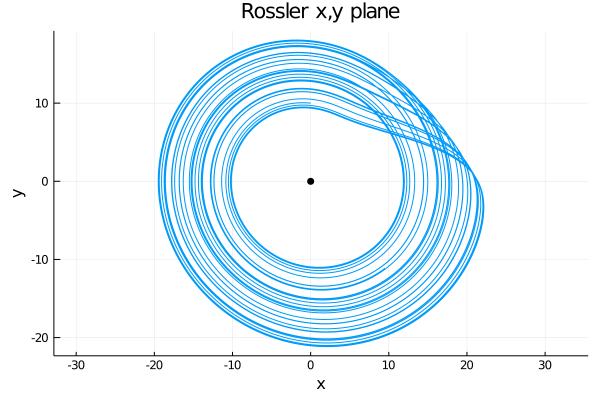

In [2]:
a,b,c = 0.1, 0.1, 14

x₀ = [0.0; 10.0; 0.01]
N = 20001
Δt = 0.01
t₀ = 0.0

(xstar0, xstar1) = rossler_eqbs(a,b,c)

f  = rossler_f(a,b,c)

t,x = rk4(f, x₀, Δt, N)

plot(x[:,1], x[:,2], label="")
scatter!([xstar0[1]], [xstar0[2]], markercolor=:black, label="")
plot!(xlabel="x",ylabel="y",aspect_ratio=:equal)
plot!(title="Rossler x,y plane")

## Define a Poincare section

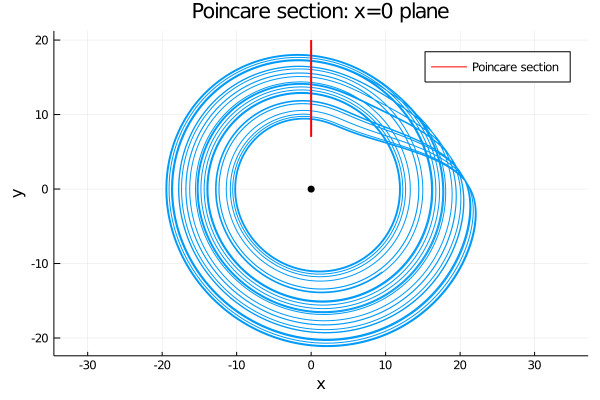

In [3]:
plot(x[:,1], x[:,2], label="")
scatter!([xstar0[1]], [xstar0[2]], markercolor=:black, label="")
plot!([0.0; 0.0], [7.0; 20.0], color=:red, width=2, label="Poincare section")
plot!(xlabel="x",ylabel="y",aspect_ratio=:equal)
plot!(title="Poincare section: x=0 plane")

In [5]:
using Polynomials

function rk4step(f, x, Δt)     
    s1 = f(x)
    s2 = f(x + Δt/2*s1)
    s3 = f(x + Δt/2*s2)
    s4 = f(x + Δt *s3)
    x + Δt/6*(s1 + 2s2 + 2s3 + s4) 
end

# From a point (x,y,z), integrate dx/dt = f(x) until it passes through the Poincare section (e.g. x=0)
# going in the positive/negative direction according to s = +/-1 

function rk4map(f, x; Δt=0.01, s=-1) 
   
    m = length(x)
    
    # initiate with five successive rk4steps (in order to do 4th-order interp later)
    # X[i,n] is ith coordinate of nth runge-kutta step
    X = zeros(m, 5)
    X[:,1] = copy(x)
    for n=1:4
        X[:,n+1] = rk4step(f, X[:,n], Δt)
    end

    p = 1
    # integrate until x crosses x[p]=0 plane, s= ±1, x[p] increasing/decreasing,
    # determined by x[2] and x[4] spanning the x[p]=0 plane
    count = 0
    while !(s*X[p,2] < 0.0 && s*X[p,4] > 0.0)
        X[:,1:4] .= X[:, 2:5]  # shift in time
        X[:,5] .= rk4step(f, X[:,4], Δt)
        count = count + 1
    end
    #@show count
    xnext = zeros(m)
    
     # Do polynomial interpolation to find x[2:end] values of x[1]=0 crossing
    for i=1:m
        polyfit = fit(X[p,:], X[i,:])
        xnext[i]= polyfit(0.0)
    end
    xnext[p] = 0.0
    xnext
end

rk4map (generic function with 1 method)

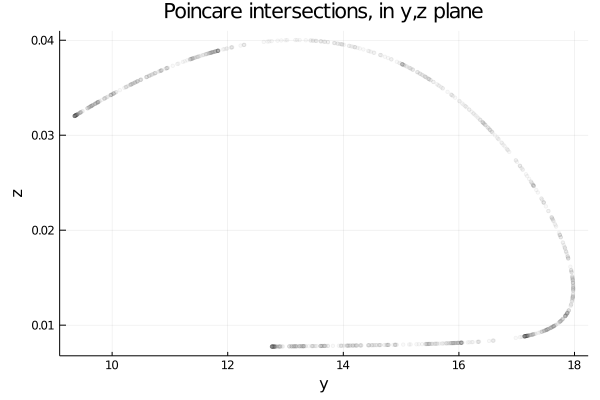

In [7]:
x₁= rk4map(f,x₀)

N = 1000
X = zeros(N,3)
X[1,:] .= x₁
for n=1:N-1
    X[n+1,:] .= rk4map(f, X[n,:])
end

X
k = 1
scatter(X[:,2], X[:,3], markersize=2, label="", color=:grey, opacity=0.05)
plot!(xlabel="y", ylabel="z")
plot!(title="Poincare intersections, in y,z plane")
#scatter(X[1:N-k,2], X[k+1:N,2])
#y = 12:22
#plot!(y,y,legend=:topleft)

## Estimate a fixed point of the Poincare map using Recurrence Plots

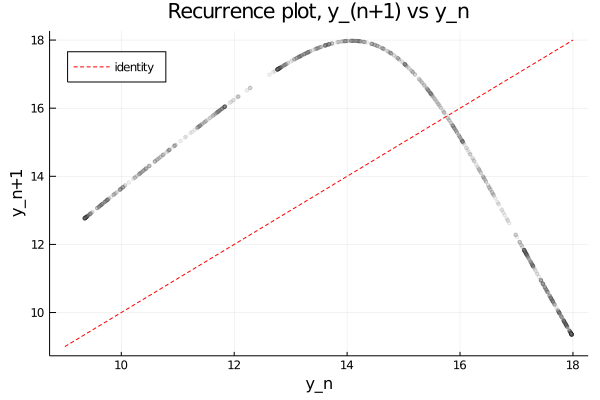

In [8]:
N = size(X,1)
k = 1
scatter(X[1:N-k,2], X[1+k:N,2], markersize=2, label="", color=:grey, opacity=0.1)
plot!([9, 18], [9, 18], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="y_n", ylabel="y_n+$k", legend=:topleft)
plot!(title="Recurrence plot, y_(n+$k) vs y_n")

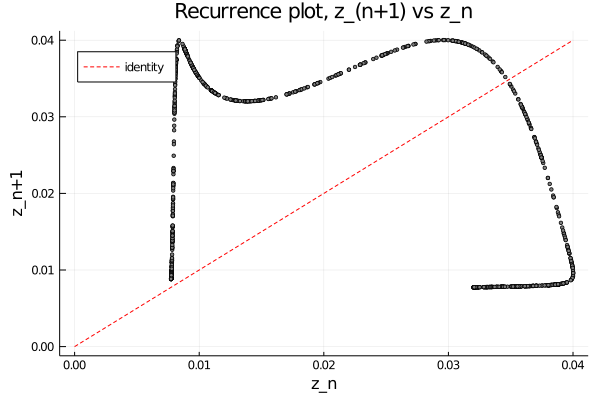

In [9]:
N = size(X,1)
k = 1
scatter(X[1:N-k,3], X[1+k:N,3], markersize=2, label="", color=:grey)
plot!([0, 0.04], [0, 0.04], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="z_n", ylabel="z_n+$k", legend=:topleft)
plot!(title="Recurrence plot, z_(n+1) vs z_n")

Guess that there's a fixed point of Poincare map at (y,z) given by intersections with identity at y≈16 and z≈0.035, and of course x=0

In [10]:
xguess3d = [0; 16; 0.035]
rk4map(f, xguess3d)

3-element Array{Float64,1}:
  0.0                
 15.143467911126143  
  0.03709290017147794

## Find the fixed point using a nonlinear solver¶

In [13]:
function F(x)
    xyz = rk4map(f, [0.0; x[1]; x[2]])
    return [xyz[2]; xyz[3]]
end
xguess = [16; 0.035]
F(xguess)

2-element Array{Float64,1}:
 15.143467911126143  
  0.03709290017147794

In [14]:
using NLsolve

solution = fixedpoint(F, xguess)

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=2 beta=1 aa_start=1 droptol=0
 * Starting Point: [16.0, 0.035]
 * Zero: [15.7629, 0.0347487]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 0

In [15]:
xstar = solution.zero
xnext = F(xstar)

@show xstar 
@show xnext
@show norm(xstar-xnext)

xstar = [15.7629, 0.0347487]
xnext = [15.7629, 0.0347487]
norm(xstar - xnext) = 3.6464323921434825e-9


3.6464323921434825e-9

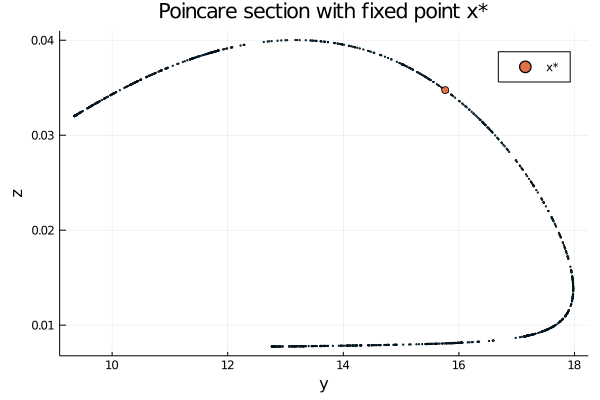

In [16]:
scatter(X[:,2], X[:,3], markersize=1, label="")
scatter!([xstar[1]], [xstar[2]], label="x*")
plot!(xlabel="y", ylabel="z")
plot!(title="Poincare section with fixed point x*")

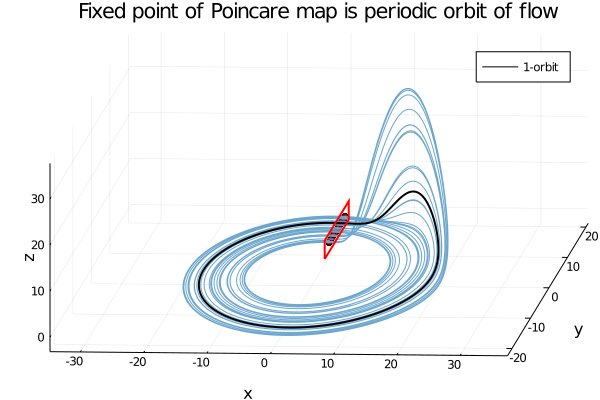

In [17]:
x₀ = [0.0; xstar[1]; xstar[2]]
Norb = Int64(round(6.4/Δt))

t,xorb = rk4(f, x₀, Δt, Norb)

scatter(X[:,1], X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(x[:,1], x[:,2], x[:,3], label="", color=:skyblue3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:black, width=2, label="1-orbit")
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal)

plot!(title="Fixed point of Poincare map is periodic orbit of flow")

## Period 2 periodic orbits

Use Recurrence plots to get a guess visually

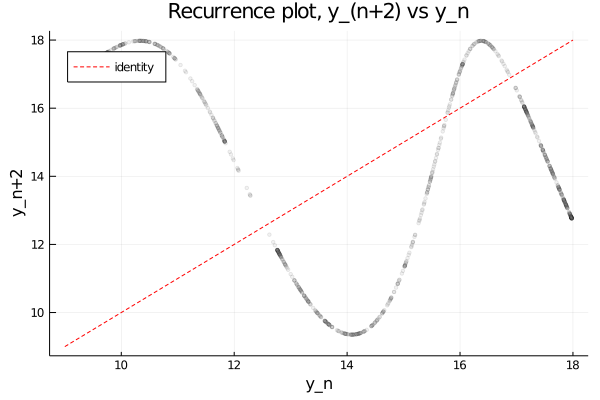

In [18]:
N = size(X,1)
k = 2
scatter(X[1:N-k,2], X[1+k:N,2], markersize=2, label="", color=:grey, opacity=0.1)
plot!([9, 18], [9, 18], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="y_n", ylabel="y_n+$k", legend=:topleft)
plot!(title="Recurrence plot, y_(n+$k) vs y_n")

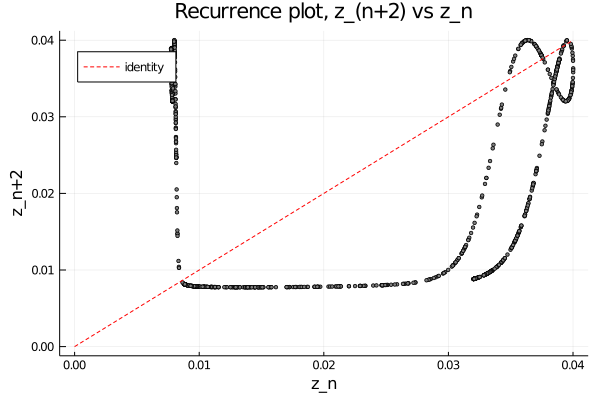

In [19]:
N = size(X,1)
k = 2
scatter(X[1:N-k,3], X[1+k:N,3], markersize=2, label="", color=:grey)
plot!([0, 0.04], [0, 0.04], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="z_n", ylabel="z_n+$k", legend=:topleft)
plot!(title="Recurrence plot, z_(n+$k) vs z_n")

Evaluate F(F(guess)) to check that it remains close to guess

In [20]:
F2(x) = F(F(x))

xguess = [17; 0.01]
F2(xguess)

2-element Array{Float64,1}:
 16.54069102893635    
  0.008346605483094982

Since it did not change much, it's a good guess. Now we can use a solver to get an accurate value for the fixed point

In [21]:
solution = fixedpoint(F2, xguess)

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=2 beta=1 aa_start=1 droptol=0
 * Starting Point: [17.0, 0.01]
 * Zero: [16.8971, 0.00858048]
 * Inf-norm of residuals: 0.000000
 * Iterations: 10
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 10
 * Jacobian Calls (df/dx): 0

In [23]:
xstar = solution.zero
xnext = F2(xstar)

@show xstar 
@show xnext
@show norm(xstar-xnext)

xstar = [16.8971, 0.00858048]
xnext = [16.8971, 0.00858048]
norm(xstar - xnext) = 8.171247655627575e-14


8.171247655627575e-14

We thus have the required point. We can iterate it using RK4 for a long enough time to trace the entire periodic orbit 

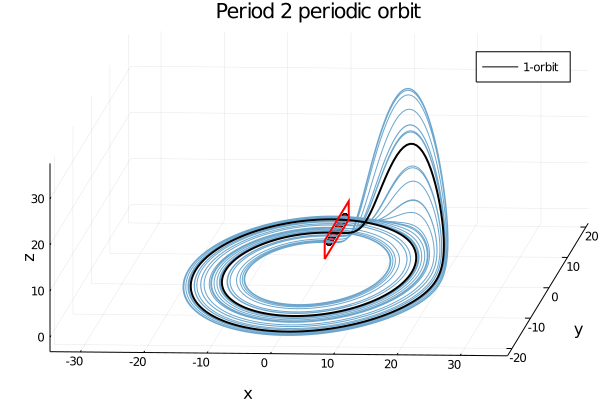

In [32]:
x₀ = [0.0; xstar[1]; xstar[2]]
Norb = Int64(round(6.4/Δt))
t,xorb = rk4(f, x₀, 2*Δt, Norb)

scatter(X[:,1], X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(x[:,1], x[:,2], x[:,3], label="", color=:skyblue3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:black, width=2, label="1-orbit")
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal)

plot!(title="Period 2 periodic orbit")

## Period 3 periodic orbit

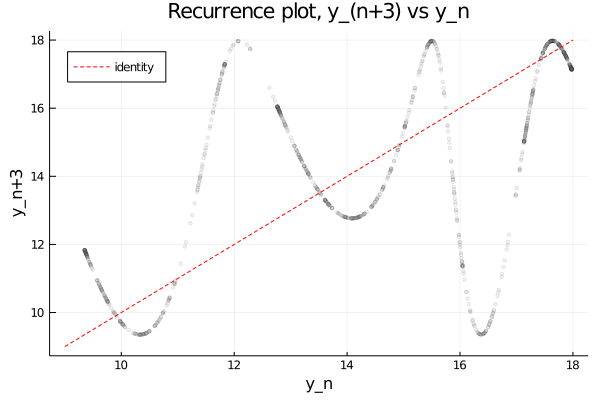

In [46]:
N = size(X,1)
k = 3
scatter(X[1:N-k,2], X[1+k:N,2], markersize=2, label="", color=:grey, opacity=0.1)
plot!([9, 18], [9, 18], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="y_n", ylabel="y_n+$k", legend=:topleft)
plot!(title="Recurrence plot, y_(n+$k) vs y_n")

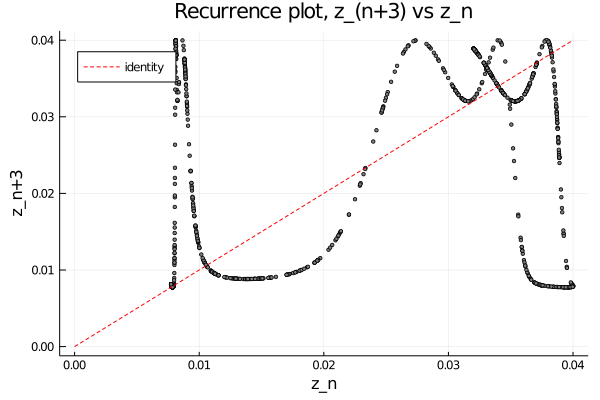

In [47]:
N = size(X,1)
k = 3
scatter(X[1:N-k,3], X[1+k:N,3], markersize=2, label="", color=:grey)
plot!([0, 0.04], [0, 0.04], color=:red, linestyle=:dash, label="identity")
plot!(xlabel="z_n", ylabel="z_n+$k", legend=:topleft)
plot!(title="Recurrence plot, z_(n+$k) vs z_n")

Check that the guess is sensible and then use a solver to evaluate the fixed point

In [38]:
F3(x) = F(F(F(x)))
xguess = [15; 0.007]
F3(xguess)

2-element Array{Float64,1}:
 15.331588256117799   
  0.007996911372597471

In [40]:
solution = fixedpoint(F3, xguess)

Results of Nonlinear Solver Algorithm
 * Algorithm: Anderson m=2 beta=1 aa_start=1 droptol=0
 * Starting Point: [15.0, 0.007]
 * Zero: [14.9269, 0.00793816]
 * Inf-norm of residuals: 0.000000
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 0

In [41]:
xstar = solution.zero
xnext = F3(xstar)

@show xstar 
@show xnext
@show norm(xstar-xnext)

xstar = [14.9269, 0.00793816]
xnext = [14.9269, 0.00793816]
norm(xstar - xnext) = 2.3261395051542012e-10


2.3261395051542012e-10

Plot the orbit using RK4 integrator

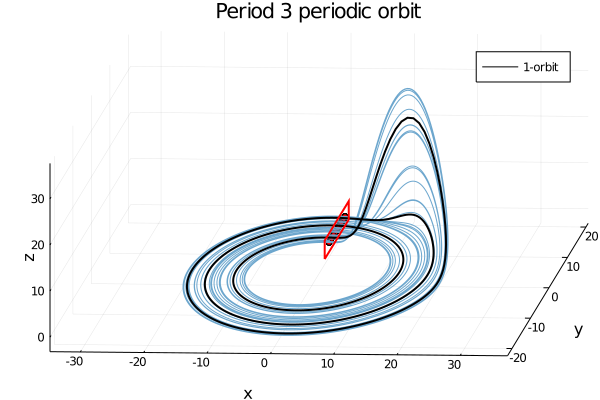

In [50]:
x₀ = [0.0; xstar[1]; xstar[2]]
Norb = Int64(round(6.4/Δt))
t,xorb = rk4(f, x₀, 3*Δt, Norb)

scatter(X[:,1], X[:,2], X[:,3], markersize=3, label="", color=:red)
plot!(x[:,1], x[:,2], x[:,3], label="", color=:skyblue3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:black, width=2, label="1-orbit")
plot!(xpoinc, ypoinc, zpoinc, color=:red, width=2, label="")
plot!(xlabel="x", ylabel="y", zlabel="z")
plot!(camera=(10,50), aspect_ratio=:equal)

plot!(title="Period $k periodic orbit")

***

*Pulkit Dubey*